In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext Cython

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [3]:
path = 'data/'
!ls data

application_test.csv	     HomeCredit_columns_description.csv
application_test.csv.zip     installments_payments.csv
application_train.csv	     installments_payments.csv.zip
application_train.csv.zip    POS_CASH_balance.csv
bureau_balance.csv	     POS_CASH_balance.csv.zip
bureau_balance.csv.zip	     previous_application.csv
bureau.csv		     previous_application.csv.zip
bureau.csv.zip		     sample_submission.csv
credit_card_balance.csv      sample_submission.csv.zip
credit_card_balance.csv.zip  subm
df_pref			     tmp


# View data

In [4]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [5]:
def display_allRows(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 10):
            display(df)

In [6]:
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')

In [7]:
bureau = pd.read_csv(path + 'bureau.csv')

In [4]:
application_train = pd.read_csv(path + 'application_train.csv')

In [24]:
# nrow = 1000
#application_train = pd.read_csv(path + 'application_train.csv')
#bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
#bureau = pd.read_csv(path + 'bureau.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
pos_cash_balance = pd.read_csv(path+'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')

# Sample balance

In [33]:
test = application_train[application_train['TARGET']==1]

In [35]:
test2 = test.append(test)

In [37]:
test2.shape, test.shape

((49650, 122), (24825, 122))

In [8]:
application_train.shape

(307511, 122)

# Feature Engineering

Code from https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [25]:
data = application_train
data.shape

(307511, 122)

In [26]:
#aggregate categorical values
def agg_cat(df, group_var, df_name):
    column_names = []
    du = pd.get_dummies(df.select_dtypes('object')) #one hot encoding
    du[group_var] = df[group_var] #putting identifying id back in
    cat = du.groupby(group_var).agg(['count','mean']) #count and average all features
    for i in cat.columns.levels[0]:
        column_names.append(df_name+'_'+i+'_sum');
        column_names.append(df_name+'_'+i+'_mean');
    
    cat.columns = column_names;
    return cat
    

In [27]:
#aggregate numeric values

def agg_num(df,group_var,df_name):
    column_names = []
    df = df.select_dtypes(exclude='object') #throw out all the categorical columns, or agg.max etc will be very slow
    num = df.groupby(group_var).agg(['sum','min','max','mean'])
    for i in num.columns.levels[0]:
        for j in ['sum','min','max','mean']:
            column_names.append(df_name+'_'+i+'_'+j)
        
    num.columns = column_names
    count_column = pd.DataFrame(df.groupby(group_var).count().max(1)).rename(columns={0:df_name+'_count'})
    count_column.rename(columns = {df.columns[1]:df_name+'_count'},inplace=True)
    num = num.merge(count_column, how='left', on=group_var)
    return num

In [40]:
#Merge bureau data
bureau_data = bureau.merge(bureau_balance, how='left', on='SK_ID_BUREAU')


KeyError: '50:'

In [28]:
#Bureau balance

#Aggregate categorical and numeric values
#%time bur_bal_cat = agg_cat(bureau_balance,'SK_ID_BUREAU','bureau_bal')
#%time bur_bal_num = agg_num(bureau_balance,'SK_ID_BUREAU','bureau_bal')

#Merge into one
#%time bureau_bal_data = bur_bal_cat.merge(right=bur_bal_num.reset_index(),how='left', on ='SK_ID_BUREAU')

#bureau.shape, bur_bal_cat.shape, bureau_bal_data.shape ,bur_bal_num.shape

CPU times: user 7.04 s, sys: 2.01 s, total: 9.05 s
Wall time: 9.05 s
CPU times: user 2.11 s, sys: 812 ms, total: 2.92 s
Wall time: 2.92 s
CPU times: user 476 ms, sys: 20 ms, total: 496 ms
Wall time: 498 ms


((1716428, 17), (817395, 16), (817395, 22), (817395, 5))

In [48]:
#Bureau data

prev_data = data #record for reference

#Aggregate categorical and numeric values
%time bureau_cat = agg_cat(bureau_data, 'SK_ID_CURR', 'bureau')
%time bureau_num = agg_num(bureau_data, 'SK_ID_CURR', 'bureau')

#Merge into data
%time data = data.merge(right=bureau_cat.reset_index(), how='left', on='SK_ID_CURR')
%time data = data.merge(right=bureau_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_bureau')

#print out size to check
prev_data.shape, bureau_cat.shape, bureau_num.shape, data.shape

CPU times: user 29.1 s, sys: 7.26 s, total: 36.4 s
Wall time: 36.4 s
CPU times: user 11.3 s, sys: 4.42 s, total: 15.7 s
Wall time: 15.7 s
CPU times: user 1.73 s, sys: 1.52 s, total: 3.25 s
Wall time: 3.25 s
CPU times: user 780 ms, sys: 496 ms, total: 1.28 s
Wall time: 1.28 s


((307511, 221), (305811, 62), (305811, 57), (307511, 340))

In [49]:
#Previous applications

prev_data = data #record for reference

#Count previous application
prev_apps_cat = agg_cat(previous_application,'SK_ID_CURR','prev_apps')
prev_apps_num = agg_num(previous_application,'SK_ID_CURR','prev_apps')

#Merge into data
data = data.merge(right=prev_apps_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=prev_apps_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_prev_apps')

#print out size to check
prev_data.shape, prev_apps_cat.shape, prev_apps_num.shape, data.shape

((307511, 340), (338857, 286), (338857, 81), (307511, 707))

In [50]:
#Installments Payments

## Average values for all other variables in installments payments
#avg_inst_cat = agg_cat(installments_payments,'SK_ID_CURR','avg_inst') #no categorical values
avg_inst_num = agg_num(installments_payments,'SK_ID_CURR','avg_inst')

#Merge into data
#data = data.merge(right=avg_inst_cat.reset_index(), how='left', on='SK_ID_CURR') #no categorical values
data = data.merge(right=avg_inst_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_avg_inst')

avg_inst_num.shape, data.shape

((339587, 29), (307511, 736))

In [51]:
#Pos cash balance

### count the number of pos cash for a given ID
pcb_cat = agg_cat(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')
pcb_num = agg_num(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')

#Merge data
data = data.merge(right=pcb_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=pcb_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_pcb')

pcb_cat.shape, pcb_num.shape, data.shape

((337252, 18), (337252, 25), (307511, 779))

In [52]:
#Credit card balance

cc_bal_cat = agg_cat(credit_card_balance,'SK_ID_CURR','credit_card_bal')
cc_bal_num = agg_num(credit_card_balance,'SK_ID_CURR','credit_card_bal')

#Merge data
data = data.merge(right=cc_bal_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=cc_bal_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_credit_card')

data.shape

(307511, 878)

In [7]:
#Save data
data.to_feather('tmp/data')
!ls tmp

data	       data_bureau_balance  data_prev_apps  df_merge_bru_preApp
data_avg_inst  data_credit_card     df_app	    test_data
data_bureau    data_pcb		    df_merge


In [177]:
#Better Feature Engineering: 
#https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
#https://www.kaggle.com/willkoehrsen/feature-selection

# Learning

In [16]:
#df_merge = pd.read_feather('tmp/df_merge')
data = pd.read_feather('tmp/data')
data.shape

(307511, 878)

In [5]:
data_sub = data[data['TARGET']==1]
data_sub.shape

(24825, 878)

In [8]:
data = data.append(data_sub)
data.shape

(381986, 878)

In [17]:
data.reset_index(drop=True, inplace=True)

In [12]:
# Data balancing
a=0;
data_append = data_sub
for i in range(9):
    data_append = data_append.append(data_sub)
data_append.shape

(248250, 878)

In [35]:
data_append.shape

(248250, 878)

In [37]:
data = data.append(data_append)
data.shape

MemoryError: 

In [19]:
data= data.reset_index()

In [30]:
data = data.drop(columns = ['index'])

In [18]:
data.to_feather('tmp/data_balanced')

In [4]:
data = pd.read_feather('tmp/data_balanced')

In [5]:
data.shape

(530936, 878)

In [17]:
train_cats(data)
#train_cats(df_app)

In [18]:
df, y, nas = proc_df(data,'TARGET')#option max_n_cat=8
#df, y, nas = proc_df(df_app,'TARGET')

In [11]:
df.shape

(381986, 1694)

In [19]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 8000
n_trn = len(df) - n_valid
#raw_train, raw_valid = split_vals(df_app, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((299511, 1694), (299511,), (8000, 1694), (8000,))

In [20]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_valid, m.predict(X_valid)),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [21]:
set_rf_samples(20000) # use reset_rf_samples() to reset

# Feature Importance

In [27]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 37s, sys: 23.5 s, total: 2min
Wall time: 1min 49s
[0.6395167816617287, 0.6333211920003846, 0.8439556477057604, 0.844125, 0.8384667007221771]


In [15]:
# m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
# %time m.fit(X_train, y_train)
# print_score(m)

CPU times: user 1min 29s, sys: 29.7 s, total: 1min 58s
Wall time: 1min 49s


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [28]:
fi = rf_feat_importance(m,X_train); fi[:10]

,cols,imp
42,EXT_SOURCE_3,0.037635
41,EXT_SOURCE_2,0.037121
40,EXT_SOURCE_1,0.014221
16,DAYS_BIRTH,0.010518
731,avg_inst_AMT_PAYMENT_min,0.008268
173,bureau_DAYS_CREDIT_max_x,0.008200
214,bureau_DAYS_CREDIT_UPDATE_mean_x,0.008082
174,bureau_DAYS_CREDIT_mean_x,0.007849
7,AMT_CREDIT,0.007413
9,AMT_GOODS_PRICE,0.007267


In [29]:
def plot_fi(fi): return fi.plot('cols','imp','barh',figsize=(12,8), legend=False)

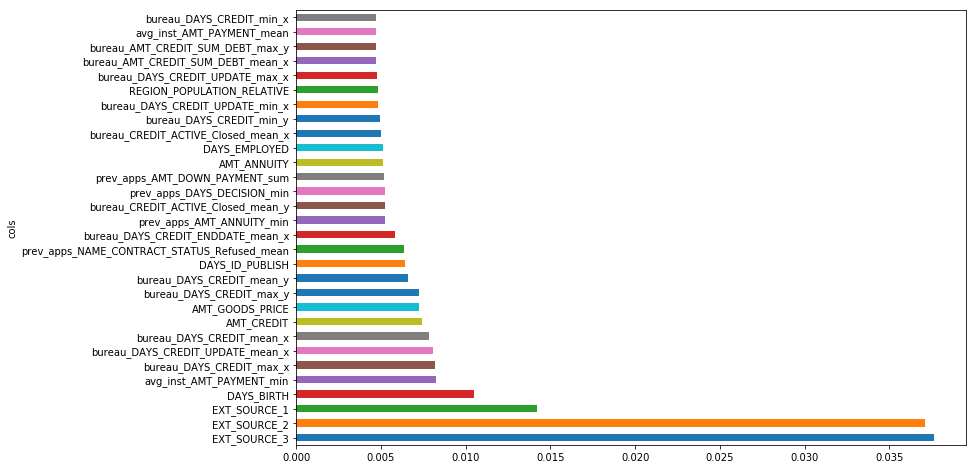

In [30]:
plot_fi(fi[:30])

In [24]:
fi[:30]

,cols,imp
42,EXT_SOURCE_3,0.041228
41,EXT_SOURCE_2,0.034966
40,EXT_SOURCE_1,0.015492
16,DAYS_BIRTH,0.010086
420,prev_apps_NAME_CONTRACT_STATUS_Refused_mean,0.008604
174,bureau_DAYS_CREDIT_mean_x,0.008153
182,bureau_DAYS_CREDIT_ENDDATE_mean_x,0.008122
289,bureau_DAYS_CREDIT_mean_y,0.007792
173,bureau_DAYS_CREDIT_max_x,0.006993
288,bureau_DAYS_CREDIT_max_y,0.006810


In [31]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

22

In [32]:
df_keep = data[to_keep].copy()

In [33]:
df, _, nas = proc_df(df_keep)

In [34]:
df.shape

(307511, 40)

In [35]:
X_train, X_valid = split_vals(df, n_trn)

In [40]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, max_depth=8, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6.84 s, sys: 600 ms, total: 7.44 s
Wall time: 4.76 s
[0.677047663613912, 0.6718069327881482, 0.7505534020453339, 0.743, 0.747865687737679]


In [41]:
m = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=8, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 49.8 s, sys: 3.92 s, total: 53.7 s
Wall time: 30.8 s
[0.6792708364072296, 0.6694885474374717, 0.7550907980007412, 0.7455, 0.7528604959417183]


# Interpretation

In [29]:
#Remove redundant features
from scipy.cluster import hierarchy as hc

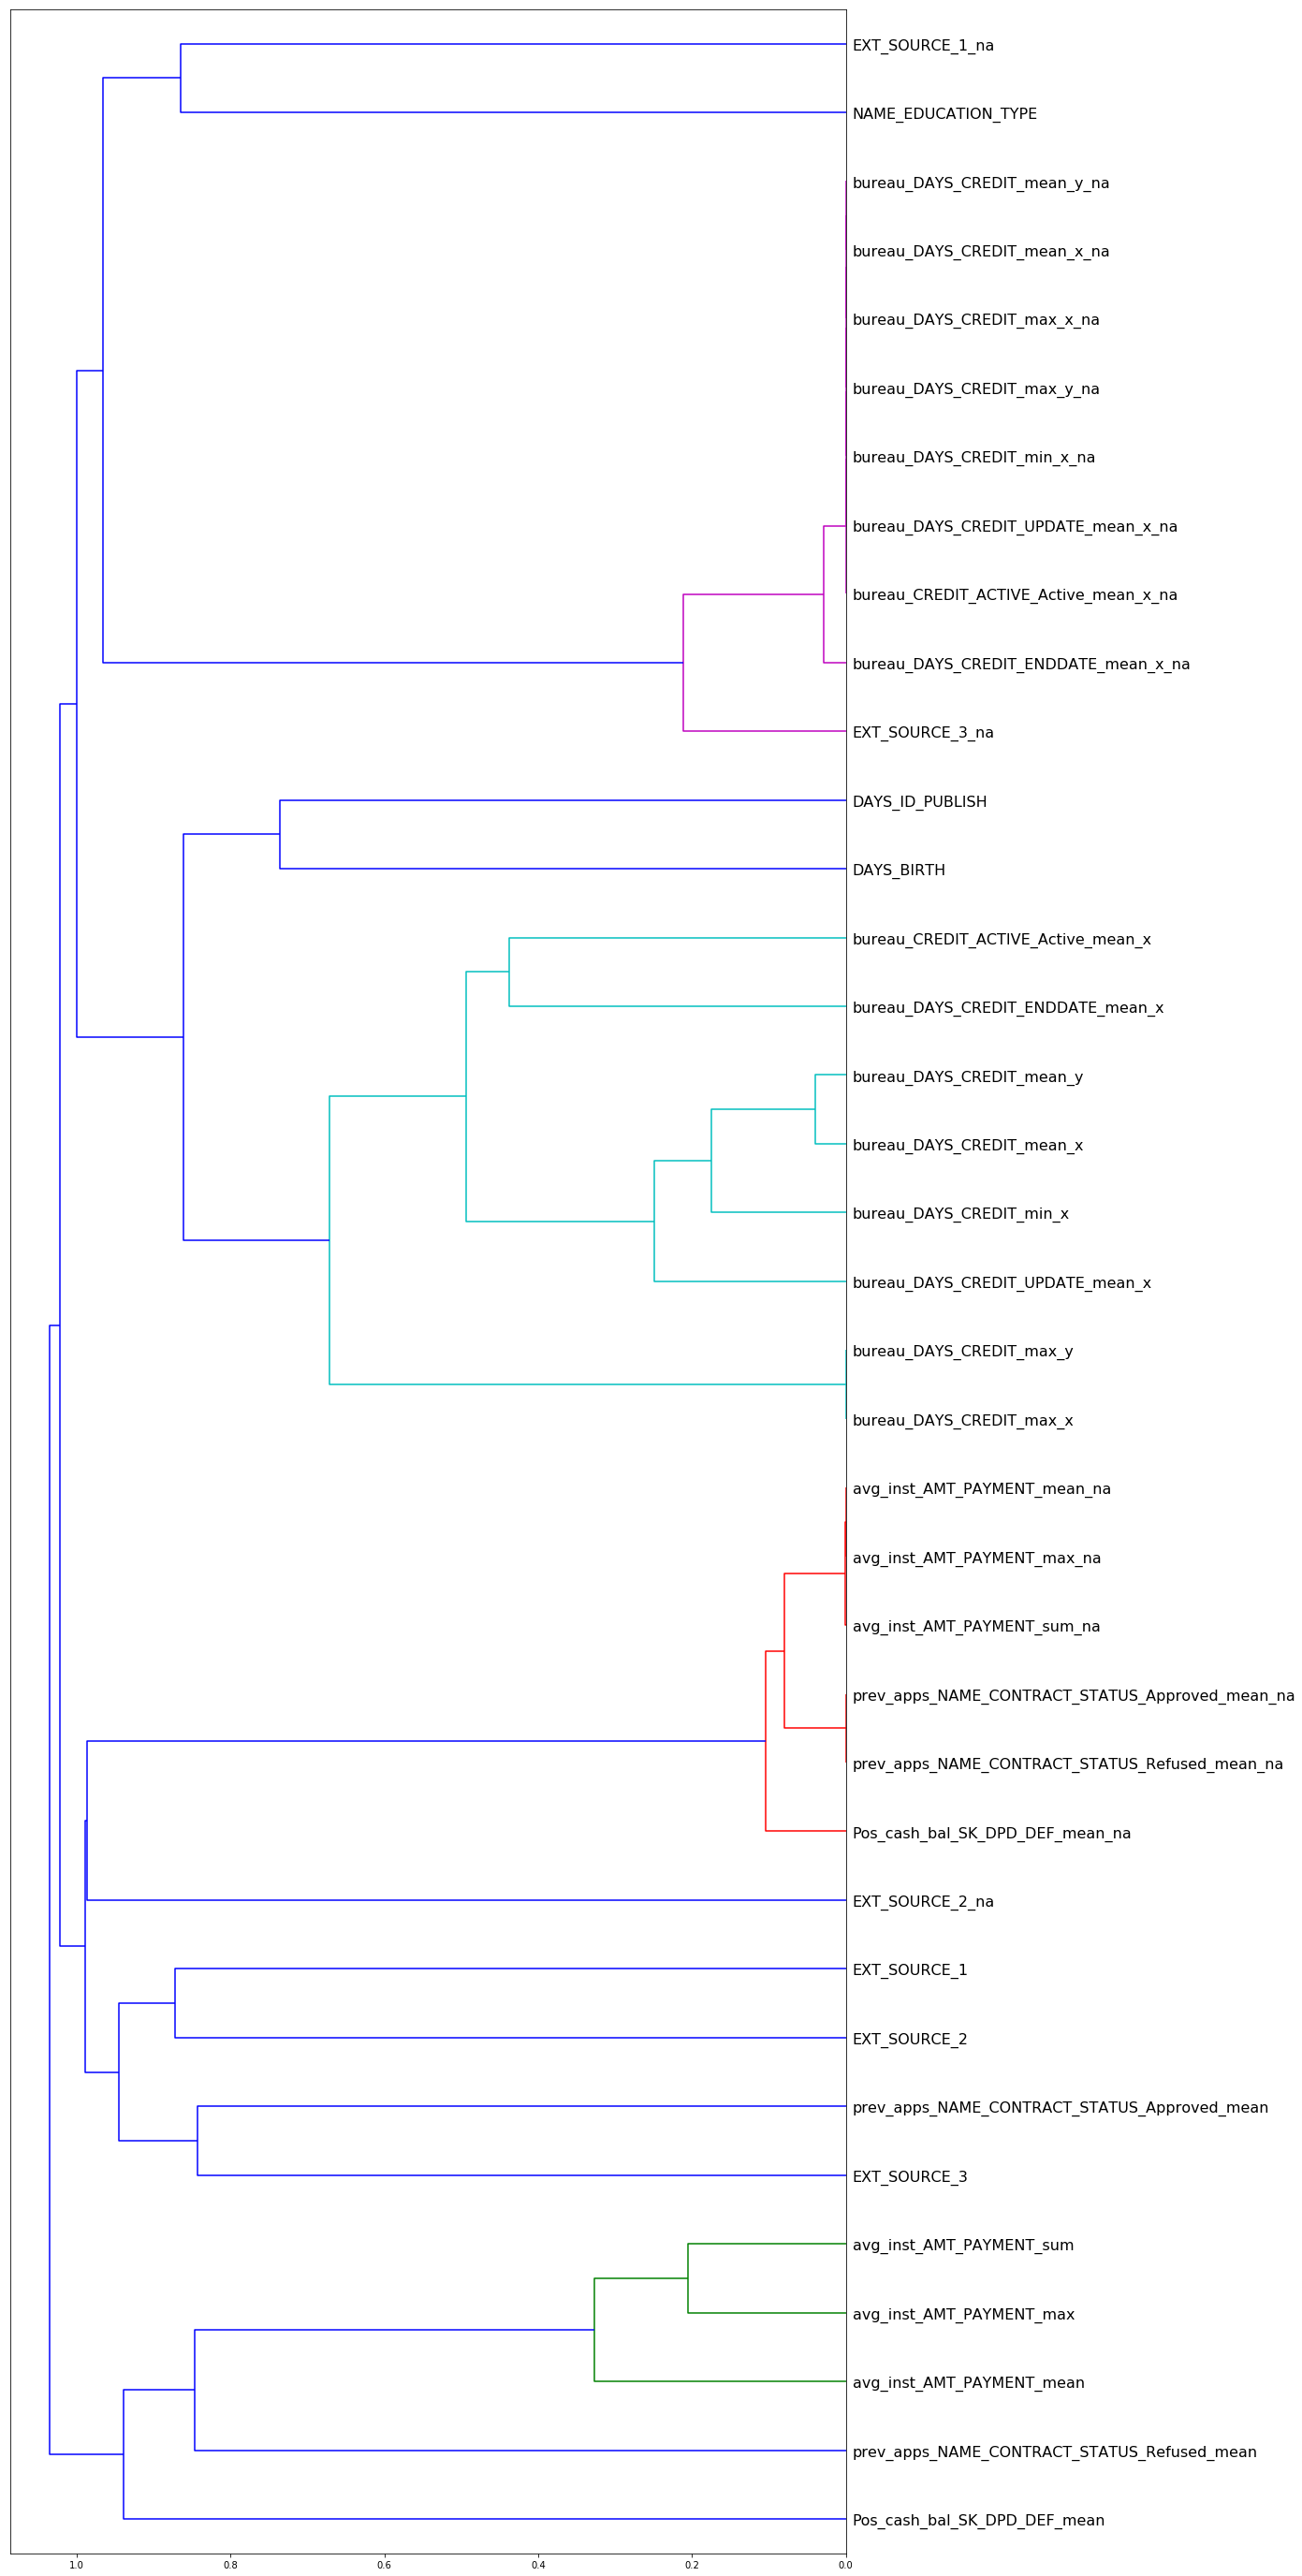

In [31]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,50))
dendrogram = hc.dendrogram(z,labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

# Test set

In [153]:
df_app_test = pd.read_csv(f'{PATH}application_test.csv', low_memory=False)

In [163]:
test_data = pd.read_feather('tmp/test_data')
test_data.shape

(48744, 189)

In [164]:
apply_cats(test_data, df_keep)

In [165]:
df_test_fi = test_data[to_keep].copy()

In [166]:
df_test_fi.shape

(48744, 60)

In [167]:
#df, y, nas = proc_df(df_app,'TARGET')

df_test,a,b = proc_df(df_test_fi,na_dict=nas) #passing in na_dict make sure the missing value columns aligns with training set

In [168]:
df_test.shape

(48744, 108)

In [169]:
predict = m.predict(df_test)

In [170]:
predict

array([0.11481, 0.12088, 0.04674, ..., 0.04852, 0.0457 , 0.16747])

In [171]:
df_pred = pd.DataFrame(predict)

In [172]:
df_pred.insert(0,'SK_ID_CURR',df_app_test['SK_ID_CURR'])

In [173]:
df_pred.rename({0:'TARGET'},axis='columns',inplace=True)

In [174]:
df_pred.head()

,SK_ID_CURR,TARGET
0,100001,0.114809
1,100005,0.120876
2,100013,0.046737
3,100028,0.049196
4,100038,0.133846


In [175]:
df_pred.to_feather(f'{PATH}df_pref')

In [176]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)
df_pred.to_csv(f'{SUBM}subm.csv', index = False)
FileLink(f'{SUBM}subm.csv')

/home/paperspace/kaggle/competitions/home-credit-default-risk/data/subm/subm.csv